In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
!git clone https://github.com/RachelTan31/-Poodle-FADING-.git

Cloning into 'FADING'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 12), reused 18 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 4.85 MiB | 21.21 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [3]:
%cd -Poodle-FADING-

/content/FADING


In [ ]:
!pip install -U pip setuptools wheel

  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.5 MB/s eta 0:00:00
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
!pip install -q diffusers transformers accelerate safetensors \
               einops timm scipy opencv-python pillow tqdm

In [4]:
# load fine-tuning data
from google.colab import drive
drive.mount('/content/drive')

import os, shutil
import numpy as np
import pandas as pd

CSV_PATH  = "/content/drive/MyDrive/subsample_200_reviewed.csv"
IMG_ROOT  = "/content/drive/MyDrive/subsample_200"

OUT_IMG_DIR = "specialization_data/training_images"
os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs("specialization_data", exist_ok=True)

df = pd.read_csv(CSV_PATH)

rows = []
for _, row in df.iterrows():
    fname = str(row["filename"]).strip()
    age_m = float(row["age_months"])

    src = os.path.join(IMG_ROOT, fname)
    dst = os.path.join(OUT_IMG_DIR, fname)

    if not os.path.exists(src):
        print("WARNING: missing image:", src)
        continue

    shutil.copy(src, dst)

    age_m_int = int(round(age_m))
    rows.append([fname, age_m_int])

ages = np.array(rows, dtype=object)
np.save("specialization_data/training_ages.npy", ages)

print("Num training samples:", len(rows))


KeyboardInterrupt: 

In [5]:
import os, numpy as np

AGE_PATH = "specialization_data/training_ages.npy"
IMG_DIR  = "specialization_data/training_images"

ages = np.load(AGE_PATH, allow_pickle=True)
print("ages shape:", ages.shape)
print("first 5 age rows:", ages[:5])

img_names = sorted(os.listdir(IMG_DIR))
print("num images:", len(img_names))
print("first 5 image filenames:", img_names[:5])

age_names = [str(a[0]) for a in ages]

missing_in_npy = [n for n in img_names if n not in age_names]
extra_in_npy   = [n for n in age_names if n not in img_names]

print("\nImages with NO age entry in training_ages.npy:", len(missing_in_npy))
print(missing_in_npy[:20])

print("\nAge entries with NO corresponding image:", len(extra_in_npy))
print(extra_in_npy[:20])


ages shape: (205, 2)
first 5 age rows: [['A_3mZySoRXT50AAAAAAAAAAAAAAQAAAQ.jpg' 1]
 ['A_XLDAQ7BrVpYAAAAAAAAAAAAAAQAAAQ.jpg' 1]
 ['ca85e5b5b9843954b49caf5df0020580.jpg' 1]
 ['A_7bb8RoLfeJoAAAAAAAAAAAAAAQAAAQ.jpg' 3]
 ['A_vaftSoyBRbUAAAAAAAAAAAAAAQAAAQ.jpg' 4]]
num images: 205
first 5 image filenames: ['0d15776fbdc86a26f4643fb726c793f5.jpg', '105448b2ca5be32a30f0786e75a80b89.jpg', '151d9f846ccc3d12cdfcd11249178e3c.jpg', '291f7d5921d649585fbfd7e05e698f67.jpg', '96cbb1b142aea0c9c84927d6831060d5.jpg']

Images with NO age entry in training_ages.npy: 0
[]

Age entries with NO corresponding image: 0
[]


In [6]:
# save the data to drive
import shutil

src = "/content/FADING/specialization_data"
dst = "/content/drive/MyDrive/specialization_data"

shutil.copytree(src, dst, dirs_exist_ok=True)
print("Copied to Google Drive!")

Copied to Google Drive!


In [5]:
# load the data to content

from google.colab import drive
drive.mount('/content/drive')

# Paths
drive_data = "/content/drive/MyDrive/specialization_data"
src_data   = "/content/FADING/specialization_data"

# Remove old copy if it exists (optional, avoids duplication)
!rm -rf $src_data

# Copy the folder from Drive into src
!cp -r $drive_data $src_data

# Verify
print("Contents of src:")
!ls /content/FADING/
print("\nContents of specialization_data:")
!ls $src_data



Mounted at /content/drive
Contents of src:
age_editing.py	 FADING_util	    p2p.py     specialization_data
FADING_demo.png  null_inversion.py  README.md  specialize.py

Contents of specialization_data:
training_ages.npy  training_images


In [6]:
# fine-tune
!accelerate launch specialize.py \
  --instance_data_dir 'specialization_data/training_images' \
  --instance_age_path 'specialization_data/training_ages.npy' \
  --output_dir 'poodle_fading_model_lr1e-6_step1500' \
  --max_train_steps 1500 \
  --learning_rate 1e-6

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-11-29 06:30:52.530210: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 06:30:52.545961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764397852.563603    2384 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register 

In [7]:
# save model to drive
import shutil

shutil.copytree(
    "poodle_fading_model_lr1e-6_step1500",
    "/content/drive/MyDrive/poodle_fading_model_lr1e-6_step1500",
    dirs_exist_ok=True
)

'/content/drive/MyDrive/poodle_fading_model_lr1e-6_step1500'

In [ ]:
# load model
import shutil
from google.colab import drive
drive.mount('/content/drive')

src = "/content/drive/MyDrive/poodle_fading_model_lr1e-6_step1500"
dst = "/content/-Poodle-FADING-/poodle_fading_model_lr1e-6_step1500"

shutil.copytree(src, dst, dirs_exist_ok=True)

print("Copied successfully!")

Mounted at /content/drive
Copied successfully!


In [8]:
from diffusers import StableDiffusionPipeline, DDIMScheduler
specialized_path = "/content/FADING/poodle_fading_model_lr1e-6_step1500"

scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

pipe = StableDiffusionPipeline.from_pretrained(
    specialized_path,
    scheduler=scheduler,
    safety_checker=None
).to(device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/30 [00:00<?, ?it/s]

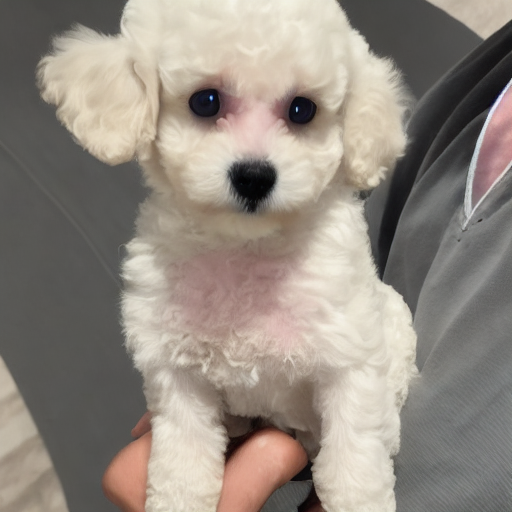

In [9]:
prompt = "a 2 month old poodle"
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
image

In [20]:
!python age_editing.py \
  --image_path "/content/drive/MyDrive/test_poodles/A__nWnR4FYmqMAAAAAAAAAAAAAAQAAAQ.jpg" \
  --age_init 91 \
  --specialized_path "poodle_fading_model_lr5e-6_step150" \
  --save_aged_dir "poodle_outputs" \
  --target_ages 6 36 84

2025-11-29 04:59:05.105637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764392345.127972   30936 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764392345.134693   30936 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764392345.151907   30936 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764392345.151936   30936 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764392345.151940   30936 computation_placer.cc:177] computation placer alr

# Generate results (from test_poodles)

In [ ]:
!fusermount -u /content/drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

# Make sure we are in the FADING repo (where age_editing.py lives)
%cd /content/FADING

# Paths in Google Drive
TEST_POODLES_DIR = "/content/drive/MyDrive/test_poodles"
CSV_PATH         = "/content/drive/MyDrive/test_poodles.csv"
OUTPUT_DIR       = "/content/drive/MyDrive/poodle_fading_model_lr1e-6_step1500"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the CSV with columns: filename, age_months
df = pd.read_csv(CSV_PATH)
print("Number of test images:", len(df))
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/FADING
Number of test images: 20


,filename,age_months
0,A__nWnR4FYmqMAAAAAAAAAAAAAAQAAAQ.jpg,91
1,A_-bxFQKfRysUAAAAAAAAAAAAAAQAAAQ.jpg,12
2,A_-o4TT5g-h38AAAAAAAAAAAAAAQAAAQ.jpg,28
3,A_-qoaTpJrBgsAAAAAAAAAAAAAAQAAAQ.jpg,49
4,A__1zHSKZ5XYcAAAAAAAAAAAAAAQAAAQ.jpg,63


In [11]:
import subprocess
from tqdm.auto import tqdm

SPECIALIZED_PATH = "poodle_fading_model_lr1e-6_step1500"

# Choose the target ages you want to generate for each poodle
TARGET_AGES = ["6", "36", "84"]  # months (young, adult, senior)

for _, row in tqdm(df.iterrows(), total=len(df)):
    filename   = row["filename"]
    age_init   = int(row["age_months"])   # age from test_poodles.csv
    image_path = os.path.join(TEST_POODLES_DIR, filename)

    if not os.path.exists(image_path):
        print(f"[SKIP] File not found: {image_path}")
        continue

    cmd = [
        "python", "age_editing.py",
        "--image_path", image_path,
        "--age_init", str(age_init),
        "--specialized_path", SPECIALIZED_PATH,
        "--save_aged_dir", OUTPUT_DIR,
        "--target_ages", *TARGET_AGES,
    ]

    try:
        subprocess.run(cmd, check=True)
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] Failed on {filename} with age_init={age_init}: {e}")


  0%|          | 0/20 [00:00<?, ?it/s]